In [1]:
# Load necessary modules and dataset 
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")

import matplotlib.pyplot as plt
from functions import *
from utils import *

In [47]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_10_0_10.0_10000.pkl'

dataset_list, param_dict = load_dataset(dataset_dir)

num_observations = 10000
num_monomers = 100

# Sample the dataset according to num_observation
# Generate random indices that will randomly pickl num_observations from the list
indices = np.random.choice(len(dataset_list[0]['observation_list']), num_observations, replace=False)

template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list'][indices]
label_list = dataset_list[0]['labels'][indices]

observation_flatten_list = [squareform(pdist(x[:num_monomers, :])).flatten() for x in X]

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
templates_flatten = [squareform(pdist(x[:num_monomers, :])).flatten() for x in template_list]

# Generate random walk for guessing structures
# num_monomers = param_dict['num_monomers']
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

In [21]:
# Log prior for metastructures
lpm = [(logprior(x, num_monomers)).tolist() for x in templates_flatten]

In [22]:
lpm

[-52.65536372194951,
 -48.30393493059452,
 -58.85499019603076,
 -59.28519152238661,
 -62.099200526555556,
 -55.157502554151904,
 -48.830453599063716,
 -59.216345434417555,
 -48.92052975559925,
 -51.188631469633286]

In [23]:
# Log likelihood for observations given metastructures
ll = [[(loglikelihood(y, x, measurement_error, num_monomers)).tolist() for x in templates_flatten] for y in observations_flatten]

In [9]:
N = num_observations
M = num_candidates

In [10]:
## import necessary modules
import os, sys
import csv
from tqdm import tqdm
import numpy as np
import torch
# from scipy.special import logsumexp
import json

In [12]:
# check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# import cmdstanpy
# cmdstanpy.install_cmdstan()   # if you don't have cmdstan installed, uncomment this line
# cmdstanpy.rebuild_cmdstan()   # if cmdstan fails to compile, try uncommenting this line

from cmdstanpy import CmdStanModel

CmdStan install directory: /mnt/home/tudomlumleart/.cmdstan
Installing CmdStan version: 2.35.0
Download successful, file: /tmp/tmpdbberh74
Extracting distribution
Unpacked download as cmdstan-2.35.0
Building version cmdstan-2.35.0, may take several minutes, depending on your system.
Installed cmdstan-2.35.0
Test model compilation


14:16:12 - cmdstanpy - INFO - compiling stan file /mnt/ceph/users/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/cryo-er.stan to exe file /mnt/ceph/users/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/cryo-er
14:18:06 - cmdstanpy - INFO - compiled model executable: /mnt/ceph/users/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/cryo-er


In [17]:
my_model = CmdStanModel(
    stan_file='./stan/20240715_WeightOptimization.stan',
    cpp_options = {
        "STAN_THREADS": True,
    }
)

14:20:26 - cmdstanpy - INFO - compiling stan file /mnt/ceph/users/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/stan/20240715_WeightOptimization.stan to exe file /mnt/ceph/users/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/stan/20240715_WeightOptimization
14:20:41 - cmdstanpy - INFO - compiled model executable: /mnt/ceph/users/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/stan/20240715_WeightOptimization


In [18]:
import multiprocessing
n_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {n_cores}")
parallel_chains = 4
threads_per_chain = int(n_cores / parallel_chains)
print(f"Number of threads per chain: {threads_per_chain}")

Number of CPU cores: 40
Number of threads per chain: 10


In [19]:
output_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/test/'
os.makedirs(output_dir, exist_ok=True)

In [27]:
v# Write json files for reading into stan program
json_filename = os.path.join(output_dir, 'data.json')
stan_output_file = os.path.join(output_dir, 'stan_output')
data_dict = {
    "M": M,
    "N": N,
    "ll_map": ll,
    "lpm_vec": lpm,
}

json_obj = json.dumps(data_dict, indent=4)

with open(json_filename, 'w') as json_file:
    json_file.write(json_obj)
    json_file.close()

In [29]:
# Run Stan model to perform MCMC sampling
data_file = json_filename

In [30]:
fit = my_model.sample(
    data=data_file,
    chains=4,
    sig_figs=8,
    parallel_chains=parallel_chains,
    threads_per_chain=threads_per_chain,
    iter_warmup=1000,
    iter_sampling=1000,
    show_console=True,
)

14:32:02 - cmdstanpy - INFO - CmdStan start processing


method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = /mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/test/data.json
init = 2 (Default)
random
seed = 30717
output
file = /tmp/tmpqsfi5jz8/20240715_WeightOptimizationf7ksixrt/20240715_WeightOptimization-20240715143202.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = 8
profile_file = profile.csv (Default)
save_cmdstan_config = false (Def

14:32:52 - cmdstanpy - INFO - CmdStan done processing


Chain [3] Iteration: 2000 / 2000 [100%]  (Sampling)

Elapsed Time: 24.14 seconds (Warm-up)
25.533 seconds (Sampling)
49.673 seconds (Total)





In [31]:
# Save Stan output, i.e., posterior samples, in CSV format, in a specified folder
fit.save_csvfiles(dir=stan_output_file)

In [ ]:
# Analyze stan file

In [32]:
fit

CmdStanMCMC: model=20240715_WeightOptimization chains=4['method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'num_chains=4']
 csv_files:
	/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/test/stan_output/20240715_WeightOptimization-20240715143202_1.csv
	/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/test/stan_output/20240715_WeightOptimization-20240715143202_2.csv
	/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/test/stan_output/20240715_WeightOptimization-20240715143202_3.csv
	/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/test/stan_output/20240715_WeightOptimization-20240715143202_4.csv
 output_files:
	/tmp/tmpqsfi5jz8/20240715_WeightOptimizationf7ksixrt/20240715_WeightOptimization-20240715143202-stdout.txt

In [33]:
import corner
import csv

In [37]:
stan_directory = stan_output_file

In [38]:
log_weights = []
lp = []
files = sorted(os.listdir(stan_directory))[-4:]
print(files)

['20240715_WeightOptimization-20240715143202_1.csv', '20240715_WeightOptimization-20240715143202_2.csv', '20240715_WeightOptimization-20240715143202_3.csv', '20240715_WeightOptimization-20240715143202_4.csv']


In [35]:
N_center = 10

In [39]:
log_weights_d = []
for file in files:
    log_weights_chain = []
    lp_chain = []
    with open('%s/%s'%(stan_directory, file), newline='') as csvfile:
        reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
        for row in reader:
            log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,N_center+1)]
            lp_chain.append(float(row["lp__"]))
            log_weights_chain.append(log_weights_row)
    log_weights = np.array(log_weights_chain)
    lp_chain = np.array(lp_chain)
    log_weights_d.append(log_weights)
    lp.append(lp_chain)


In [41]:
log_weights_d = np.array(log_weights_d)

In [43]:
log_weights_d.shape

(4, 1000, 10)

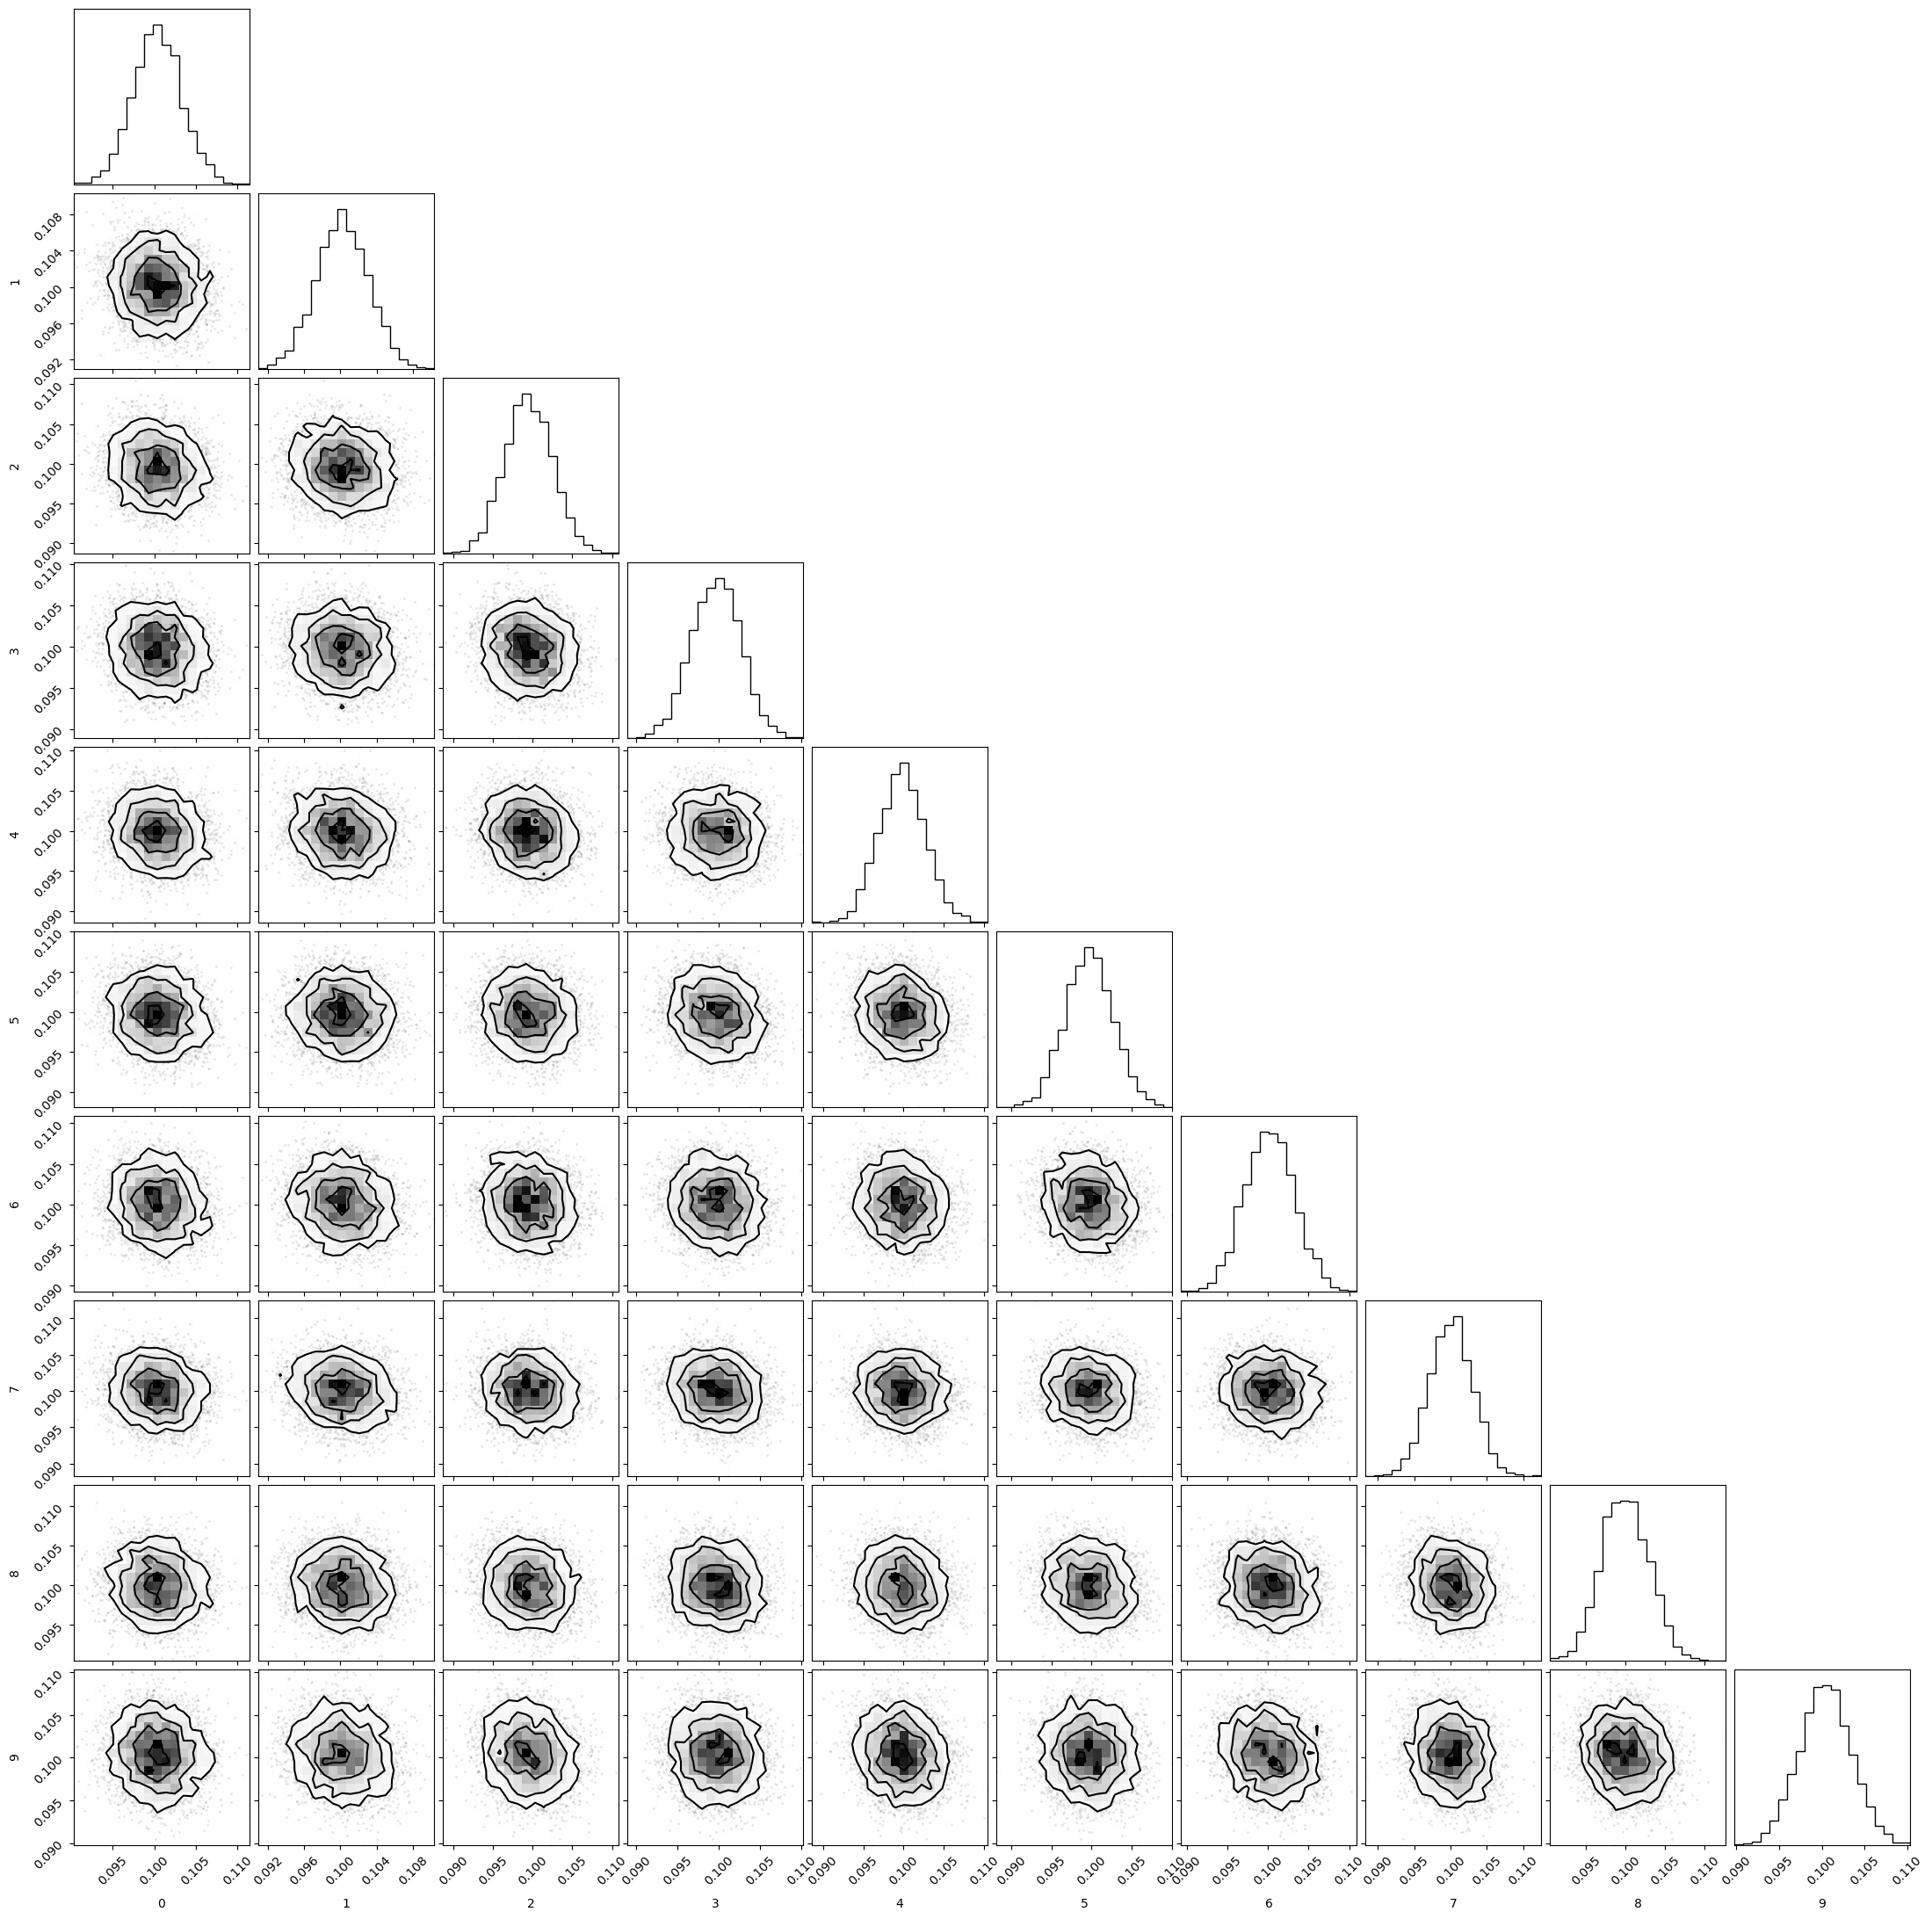

In [45]:
## make corner plot
log_weights_d_flat = log_weights_d.reshape(-1, N_center)
corner.corner(np.exp(log_weights_d_flat), labels=[str(i) for i in range(N_center)])
plt.savefig(output_dir + 'corner_plot.png')